In [1]:
import os
import cv2
import json
import argparse
import warnings
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from models.resnet import resnet_swap_2loss_add as resnet
from models.mobilenetV3 import MobileNetV3 as mobilenet

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Params
MODEL_LIO_DIR = 'weights/intelComp/resnet_w_LIO/np_5/resnet_sgd.pth'
MODEL_NORM_DIR = 'weights/intelComp/resnet/resnet_sgd.pth'
NUM_CLASSES = 9
WITH_CBAM = False
RESOLUTION = 512

In [5]:
# print torch and cuda information
print('=========== torch & cuda infos ================')
print('torch version : ' + torch.__version__)
print('available: ' + str(torch.cuda.is_available()))
print('count: ' + str(torch.cuda.device_count()))
torch.backends.cudnn.benchmark = True

=========== torch & cuda infos ================
torch version : 1.8.0+cu111
available: True
count: 1


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('{} will be used in the training process !!!'.format(device))

cuda:0 will be used in the training process !!!


In [7]:
# Load model
model_res_LIO = resnet(stage=3, in_dim=2048, num_classes=NUM_CLASSES, size=int(7/448 * RESOLUTION), with_LIO=False, with_CBAM=WITH_CBAM)
model_res = resnet(stage=3, in_dim=2048, num_classes=NUM_CLASSES, size=int(7/448 * RESOLUTION), with_LIO=False, with_CBAM=WITH_CBAM)
model_res_LIO.to(device), model_res.to(device)
pass

In [8]:
# load weight
def load_weight(model, model_dir):
    try:
        assert os.path.isfile(model_dir), 'Error: no checkpoint directory found!'
        checkpoint = torch.load(model_dir)
        model.load_state_dict(checkpoint['model'])
        print('{} : weights loaded!'.format(model_dir))
    except:
        pass
    return model

In [9]:
model_res_LIO = load_weight(model_res_LIO, MODEL_LIO_DIR)
model_res = load_weight(model_res, MODEL_NORM_DIR)

weights/intelComp/resnet_w_LIO/np_5/resnet_sgd.pth : weights loaded!
weights/intelComp/resnet/resnet_sgd.pth : weights loaded!


In [10]:
target_layer_LIO = [list(model_res_LIO.children())[-5][2]]
print('model target layers: ')
print(target_layer_LIO)

model target layers: 
[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


In [11]:
target_layer_NORM = [list(model_res.children())[-5][2]]
print('model target layers: ')
print(target_layer_NORM)

model target layers: 
[Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)]


In [12]:
# =============================================================================
# GradCAM visualization
# Construct the CAM object once, and then re-use it on many images:
cam_LIO = GradCAM(model=model_res_LIO, target_layers=target_layer_LIO, use_cuda=True)
cam_NORM = GradCAM(model=model_res, target_layers=target_layer_NORM, use_cuda=True)

# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = None

In [13]:
with open('class-index.json') as f:
    data = json.load(f)
print(data)

{'normal-cecum': 1, 'normal-z-line': 2, 'polyps': 3, 'dyed-lifted-polyps': 4, 'ulcerative-colitis': 5, 'dyed-resection-margins': 6, 'normal-pylorus': 7, 'esophagitis': 8, 'normal': 9}


In [14]:
INDEX = 3
df_test = pd.read_csv("testing.csv", dtype={'ImagePath': str, 'index': int})
df_test = df_test[df_test['index'] == INDEX]
print('testing: {}'.format(df_test.shape))
df_test.head()

testing: (388, 4)


orig_path   label  index  \
0   Kvasir v2/polyps/polyps/79dc9bef-366a-45af-b9d...  polyps      3   
18  Kvasir v2/polyps/polyps/dbec48ea-ff3c-45a0-932...  polyps      3   
26  Kvasir v2/polyps/polyps/354404bd-4f71-4a1a-b2a...  polyps      3   
31  Kvasir v2/polyps/polyps/cf27dbea-dced-46c9-b4c...  polyps      3   
38  Kvasir v2/polyps/polyps/42b05fc5-0c15-4236-95e...  polyps      3   

    ImagePath  
0   00001.jpg  
18  00019.jpg  
26  00027.jpg  
31  00032.jpg  
38  00039.jpg

In [15]:
preprocessing = transforms.Compose([
    transforms.CenterCrop((512,512)),
    transforms.Resize((RESOLUTION,RESOLUTION)),
])

1.0


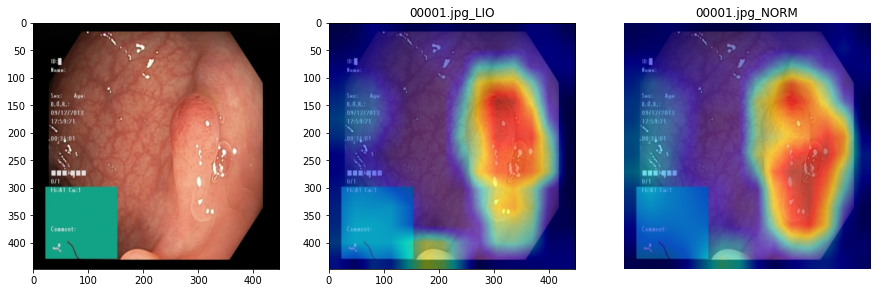

1.0


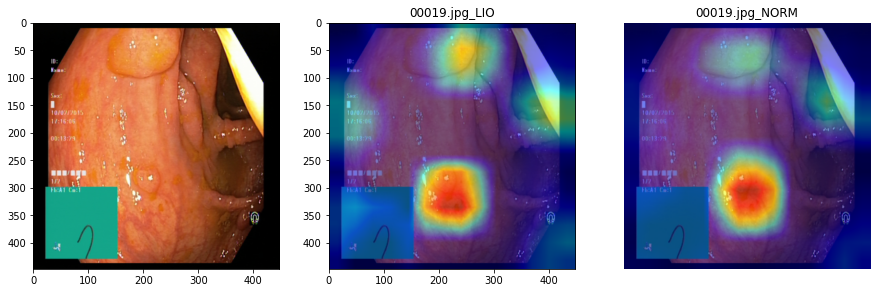

1.0


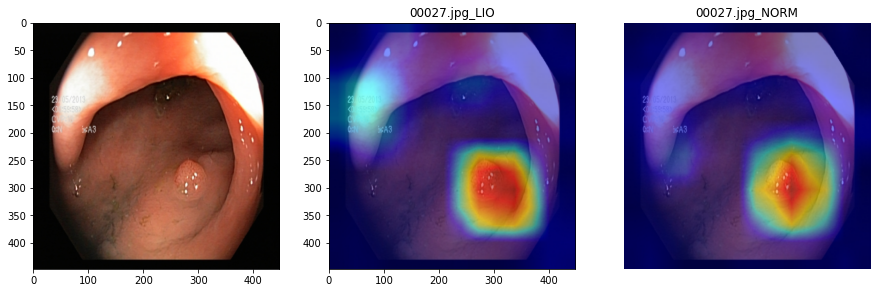

1.0


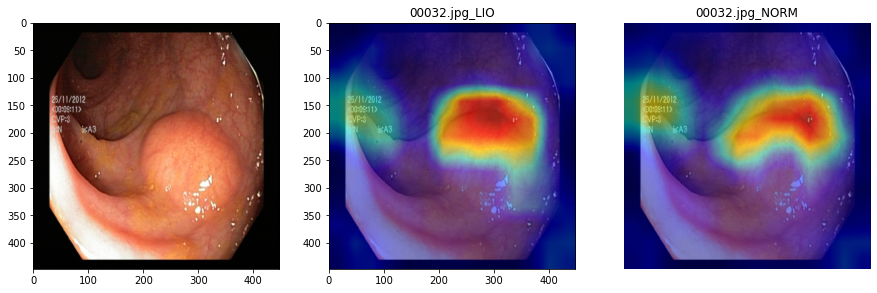

1.0


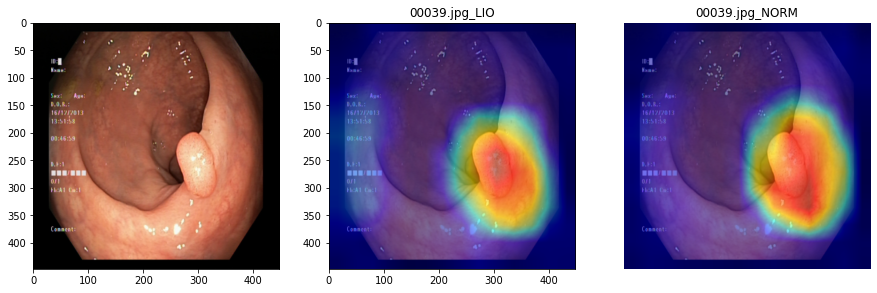

1.0


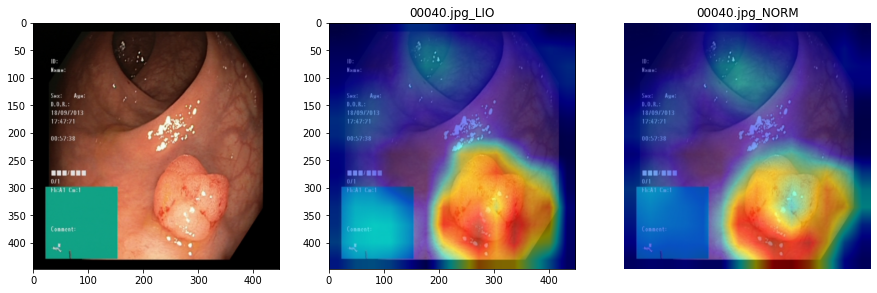

0.99561214


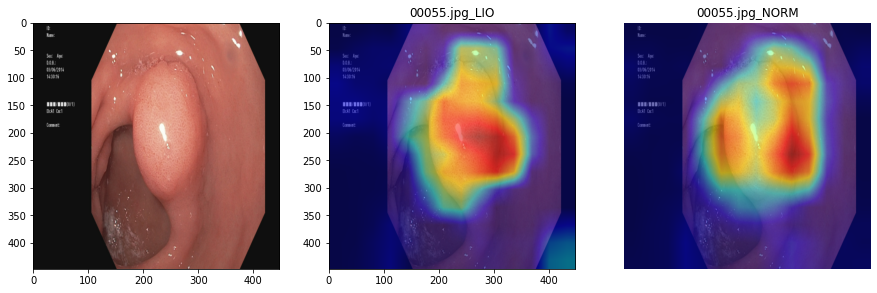

1.0


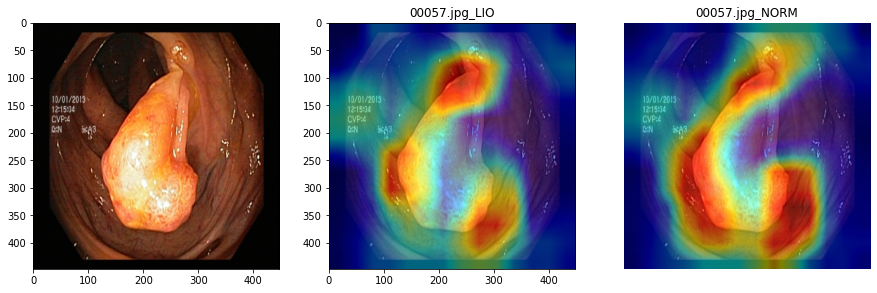

1.0


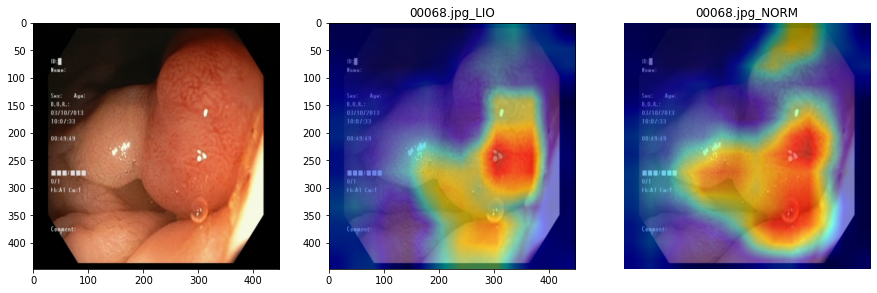

1.0


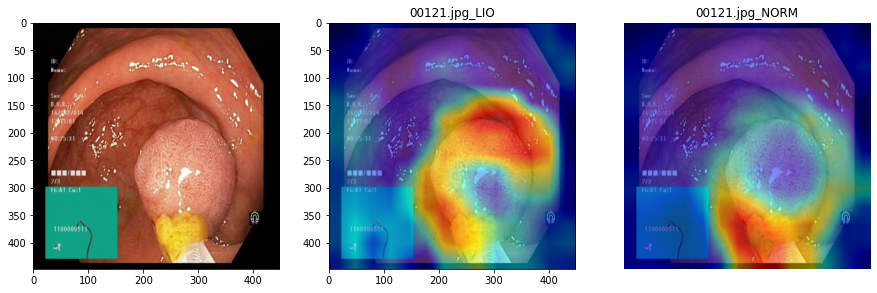

0.9994481


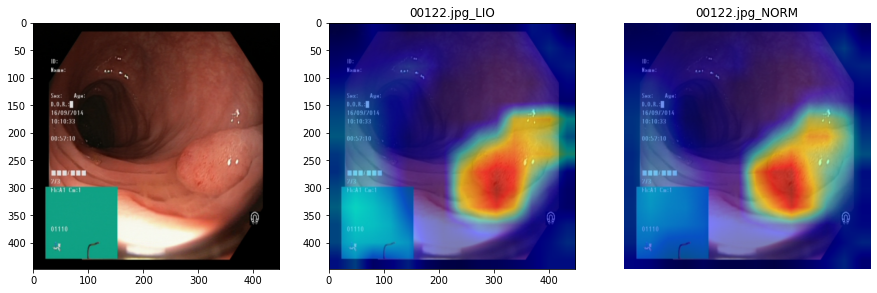

1.0


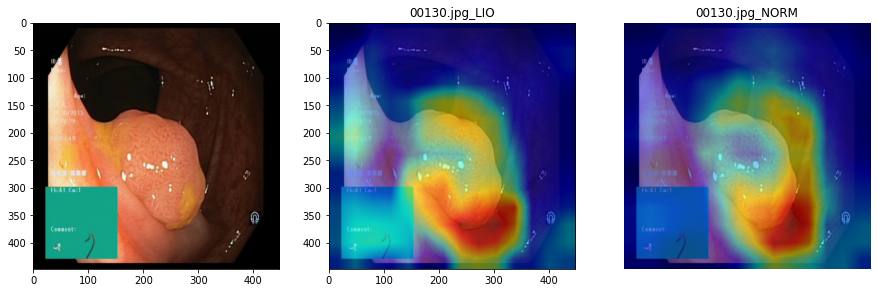

0.9999999


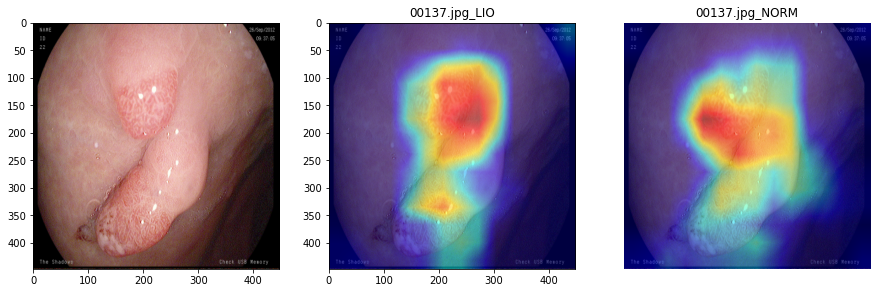

1.0


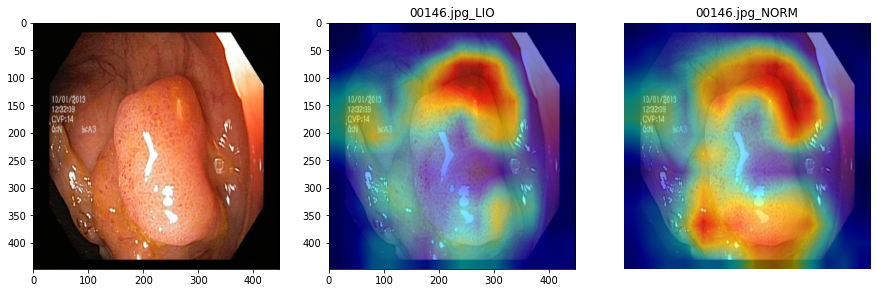

1.0


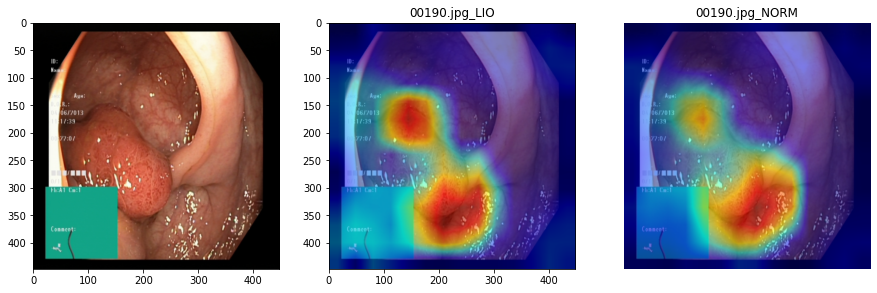

1.0


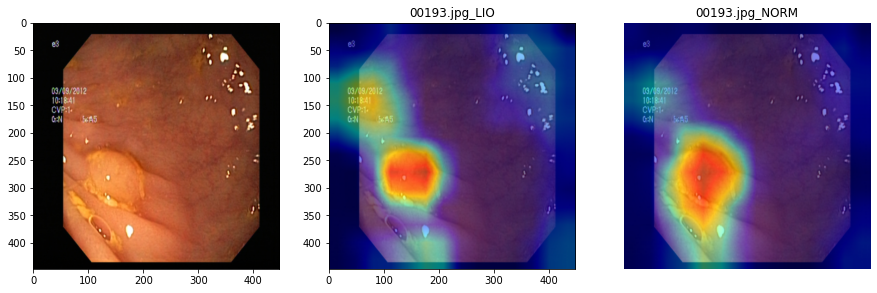

1.0


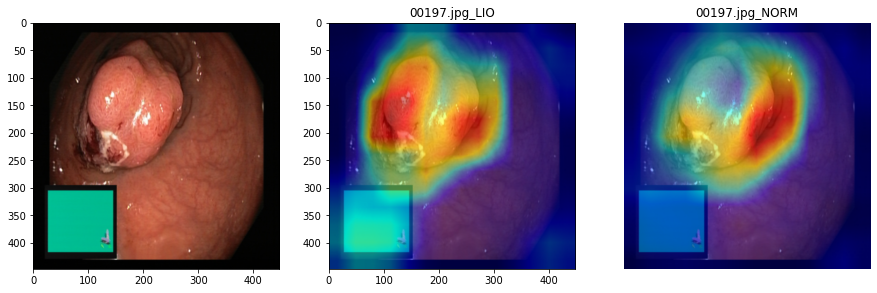

1.0


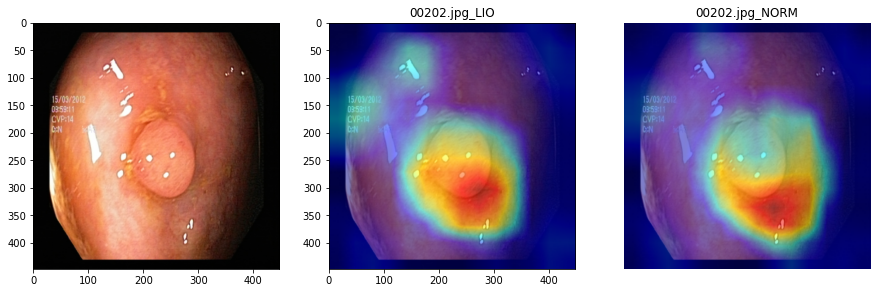

1.0


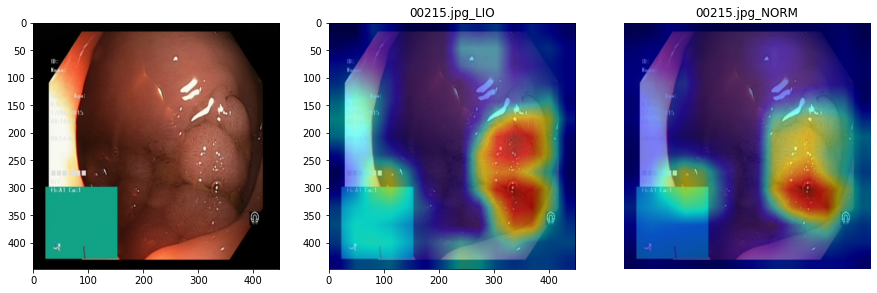

1.0


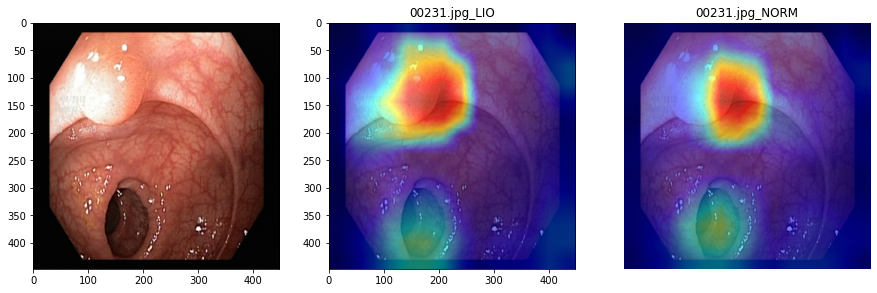

1.0


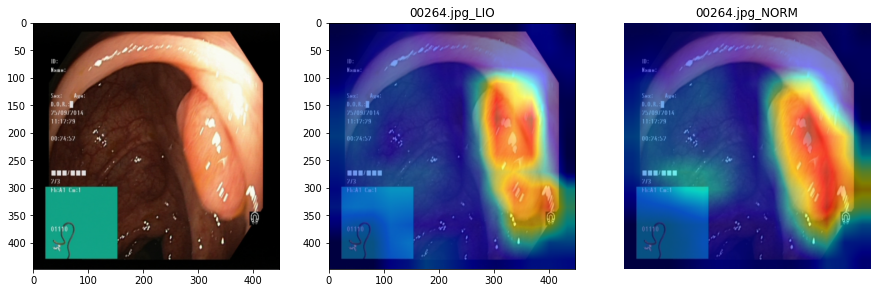

1.0


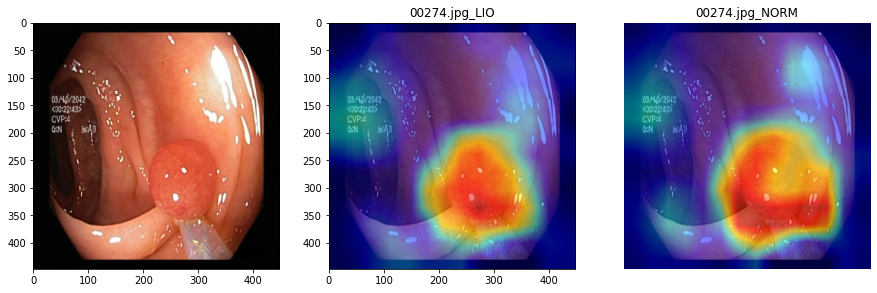

1.0


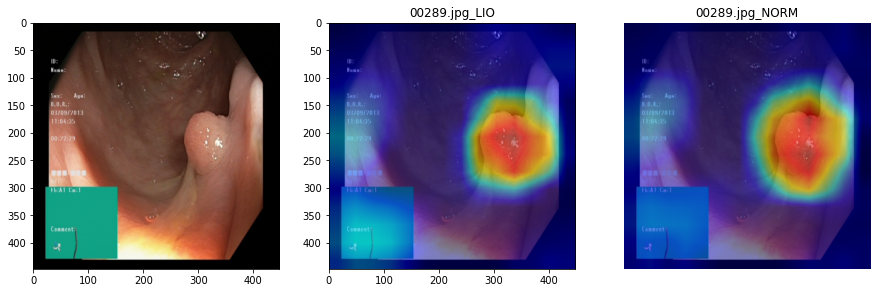

1.0


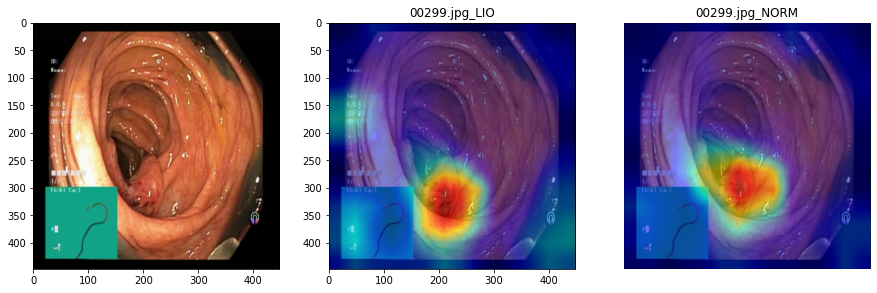

1.0


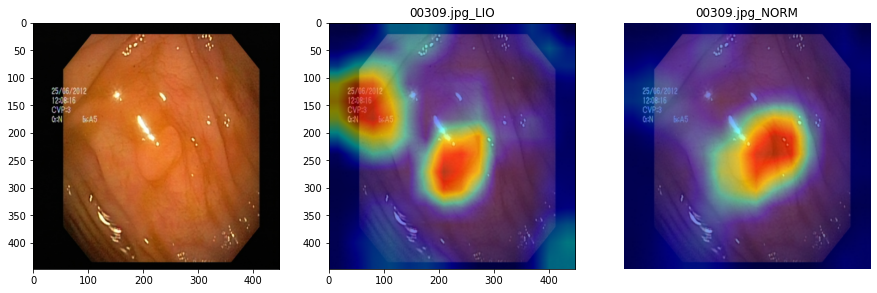

1.0


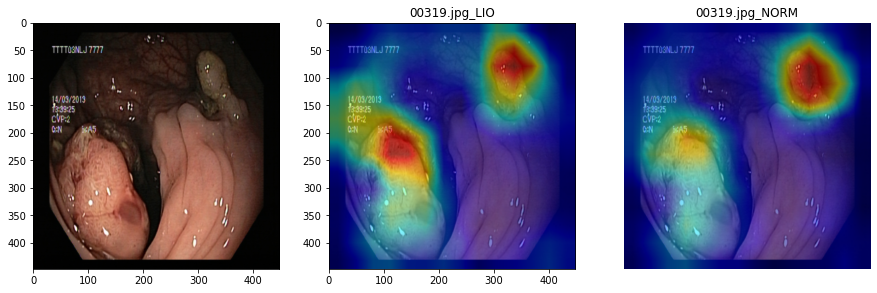

1.0


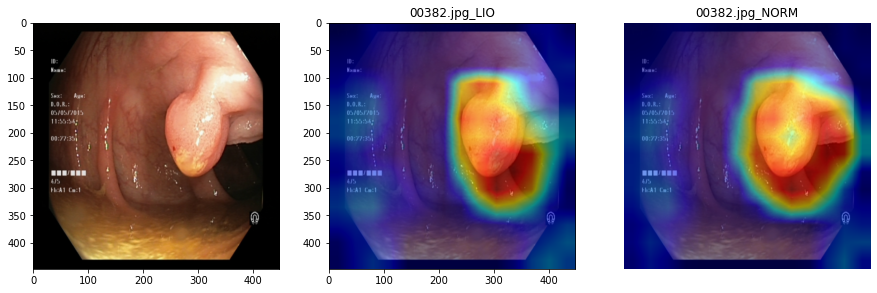

1.0


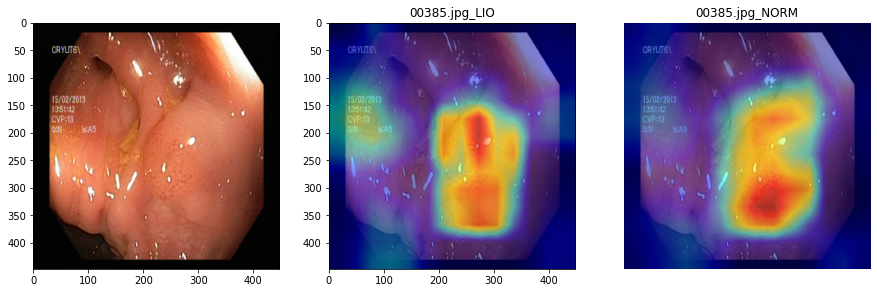

1.0


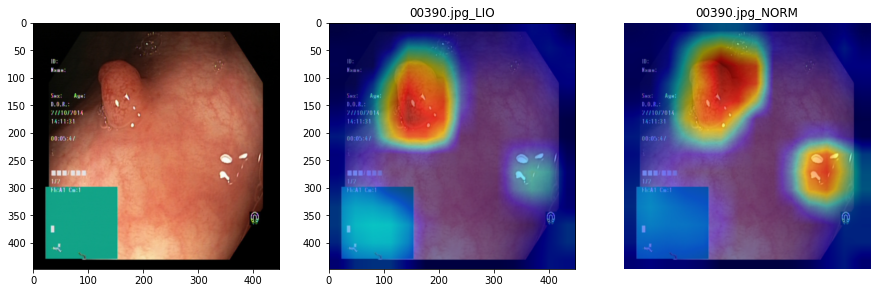

1.0


In [ ]:
for path in df_test['ImagePath'].values:
    plt.figure(figsize=(15,5))

    image = Image.open('kvasirV2/test/{}'.format(path))
    input_tensor = preprocessing(image.copy()).unsqueeze(0)
    bg_image = (np.array(image) / 255.0).astype('float32')
    bg_image = cv2.resize(bg_image, (448, 448), interpolation=cv2.INTER_AREA)
    bg_image = np.clip(bg_image, 0, 1)

    plt.subplot(1, 3, 1)
    plt.imshow(bg_image)

    idx = 1
    for cam, tp in zip([cam_LIO, cam_NORM], ['LIO', 'NORM']):
        idx += 1
        plt.subplot(1, 3, idx)
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(bg_image, grayscale_cam,use_rgb=True)
        plt.title(path + '_' + tp)
        plt.imshow(visualization)

    plt.axis('off')
    plt.show()